In [1]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/Users/htian/Documents/projects/ploth/')
import ploth as pth
# from testcase import TestCase
# from testutils import RunTests
# from mock import Mock, sentinel, patch

In [2]:
%matplotlib inline
# common functions used in the project of VR-R in GAC direction
import numpy as np
#import scipy.linalg as splin
import numpy.linalg as nl
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick',labelsize=20)
matplotlib.rc('ytick',labelsize=20)
font = {'size' : 20}
matplotlib.rc('font', **font)
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.optimize import curve_fit
import scipy.stats as stats
import scipy.special as special
import astropy.io.fits as fits
import emcee
import corner
# f = open('fevrvtvz.dat')
# VT = f.readlines()
# f.close()

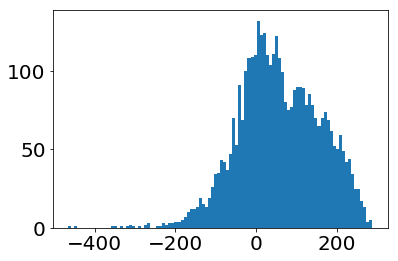

3827


In [3]:
fn_tag = "KGIANT_5fehbi_"
# data = np.loadtxt("/Users/htian/Documents/work/data/rothalo/"+fn_tag+"fehvrvtvz.dat")
data = np.loadtxt("/Users/htian/Documents/work/data/rothalo/fehvrvtvz.dat")
# data = np.loadtxt("/Users/htian/Documents/work/data/rothalo/VLSR_240fehvrvtvz.dat")
vt = data[:,2]
feh = data[:,0]
plt.hist(vt,100)
plt.show()
print(len(vt))

In [4]:

def MC_error(x,err):
    return np.random.normal(loc=x,scale=err)
   
def straightline(x,a,b):
    '''
    Straightline function
    '''
    return a + b*x

#Calculate velocity distribution at each bin, using Bayesian model
def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
#hierachical Beyasian model

def gauss_model(y):
    # sampling
    n = len(y)
    y_bar = np.mean(y)
    s2 = np.var(y)
    
    #step 1: draw sigma2 from posterior density of 
    #        sigma2 given v, p(sigma2|y)
    N = 5000
    sigma2 = randDraw_SInvChi2(n-1,s2, N)
    #step 2 : draw mu from p(mu|sigma2,y)
    mu = np.random.normal(loc=y_bar, \
            scale=np.sqrt(sigma2/n))
    popt = np.array([n,np.mean(mu),np.mean(np.sqrt(sigma2))])
    pcov = np.array([[1.0,0.0,0.0],[0.0,np.var(mu),0.0],\
                     [0.0,0.0,np.var(np.sqrt(sigma2))]])
    return popt, pcov

def lnprob_gauss(x,y):
    mu1 = x[0]
    sig1 = x[1]
    if np.isinf(mu1) or np.isinf(sig1) or sig1<0 or\
               np.abs(mu1)>100 :
        return -1e50
    g = stats.norm.pdf(y,mu1,sig1)# np.exp(-(y-mu1)**2/(2*sig1**2))/(np.sqrt(2*np.pi)*sig1)
    ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
    return np.sum(np.log(g[ind_g]))

def gauss_mcmcmodel(y):
    # MCMC sampling
    #n = len(y)
    
    #start to configure emcee
    nwalkers = 20
    ndim = 2
    p0=np.zeros((nwalkers,ndim))
    p0[:,0] = np.random.rand(nwalkers)*50-25
    p0[:,1] = np.random.rand(nwalkers)*40+20
      
    sampler = emcee.EnsembleSampler(nwalkers, \
            ndim, lnprob_gauss, args=[y])
    
    pos, prob, state = sampler.run_mcmc(p0, 100)
    sampler.reset()
    
    sampler.run_mcmc(pos, 10000)
    
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
    #corner.corner(samples)
    popt = np.median(samples, axis=0)
    pcov = np.zeros((ndim,ndim))
    for i in range(ndim):
        for j in range(ndim):
            pcov[i,j] = (np.sum((samples[:,i]-popt[i])*\
                (samples[:,j]-popt[j])))/len(samples)
    return popt, pcov


def lnprob_gauss2(x,y):
    #n = np.float(len(y))
    f1 = x[0]
    mu1 = x[1]
    sig1 = x[2]
    mu2 = x[3]
    sig2 = x[4]
    if np.isinf(f1) or np.isinf(mu1) or np.isinf(sig1) or\
                np.isinf(mu2) or np.isinf(sig2) or\
                f1<0 or f1>1 or sig1<0 or sig2<0 or\
                sig1>200 or sig2>200 or\
                mu1>100 or mu1<-50 or mu2>300 or mu2<100:
        return -1e100
    g1 = f1*stats.norm.pdf(y,mu1,sig1)# np.exp(-(y-mu1)**2/(2*sig1**2))/(np.sqrt(2*np.pi)*sig1)
    g2 = (1-f1)*stats.norm.pdf(y,mu2,sig2)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
    g = g1+g2
    #print g
    ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
    logg = np.log(g[ind_g])
    ind_lg = logg>-1e100
    return np.sum(logg[ind_lg])

def gauss2_model(y,p0,N, func, nwalkers):
    # MCMC sampling
    ndim = p0.shape[1]
    print(ndim)
    sampler = emcee.EnsembleSampler(nwalkers, \
            ndim, func, args=[y])
    N_burn_in = 2000
    
    pos, prob, state = sampler.run_mcmc(p0, N_burn_in)
    sampler.reset()
    
    sampler.run_mcmc(pos, N)
    
    samples = sampler.chain[:, N_burn_in:, :].reshape((-1, ndim))
    #corner.corner(samples)
    popt = np.median(samples, axis=0)
    pcov = np.zeros((ndim,ndim))
    for i in range(ndim):
        for j in range(ndim):
            pcov[i,j] = (np.sum((samples[:,i]-popt[i])*\
                (samples[:,j]-popt[j])))/len(samples)
    return popt, pcov, samples

import time

In [5]:
# nwalkers = 50
# ndim = 5
# p0=np.zeros((nwalkers,ndim))
# p0[:,0] = np.random.rand(nwalkers)*0.2+0.5
# p0[:,1] = np.random.rand(nwalkers)*100-50
# p0[:,2] = np.random.rand(nwalkers)*40+60
# p0[:,3] = np.random.rand(nwalkers)*100+100
# p0[:,4] = np.random.rand(nwalkers)*60+40
# start = time.time()
# Mpopt,Mpcov, samples = gauss2_model(vt, p0, 5000, lnprob_gauss2, nwalkers)
# print(time.time()-start)

In [6]:
# import corner
# ss = np.sqrt(np.diag(Mpcov))
# print(ss)
# print('f=%(f).3f\pm%(fe).3f' % {'f':Mpopt[0],'fe':ss[0]})
# print('v_1=%(v1).0f \pm %(v1e).0f km/s,\sigma_1=%(s1).0f \pm %(s1e).0f km/s' % {'v1':Mpopt[1],'v1e':ss[1],\
#                                                     's1':Mpopt[2],'s1e':ss[2]})
# print('v_2=%(v2).0f \pm %(v2e).0f km/s,\sigma_2=%(s2).0f \pm %(s2e).0f km/s' % {'v2':Mpopt[3],'v2e':ss[3],\
#                                                     's2':Mpopt[4],'s2e':ss[4]})
# fig = corner.corner(samples,labels=["$f$","$V_{T,1}$","$\sigma_{T,1}$","$V_{T,2}$","$\sigma_{T,2}$"],\
#                    truths=Mpopt)

In [7]:
# vgrid = np.arange(-400,300,10.)
# vcenter = (vgrid[:-1]+vgrid[1:])/2.
# fig = plt.figure(figsize=[12,10])
# ax = fig.add_subplot(111)
# h,xedge = np.histogram(vt,vgrid)
# ax.errorbar(vcenter, h, yerr=np.sqrt(h),fmt='ko')
# g1 = Mpopt[0]*stats.norm.pdf(vcenter,Mpopt[1],Mpopt[2])
# g2 = (1-Mpopt[0])*stats.norm.pdf(vcenter,Mpopt[3],Mpopt[4])
# g = g1+g2
# ax.plot(vcenter, g1/np.sum(g)*np.sum(h),'r--')
# ax.plot(vcenter, g2/np.sum(g)*np.sum(h),'b--')
# ax.plot(vcenter, g/np.sum(g)*np.sum(h),'g-')

# fig.show()
# fig = plt.figure(figsize=[12,4])
# ax = fig.add_subplot(111)
# ax.errorbar(vcenter, h-g/np.sum(g)*np.sum(h),yerr=np.sqrt(h),fmt='ko')
# ax.plot([-400,300],[0,0],'r-.')
# fig.show()

In [8]:
nx = np.sum(vt<0)
ny = np.float(len(vt))
print(nx/ny*2.)
print(np.sqrt(nx*(nx+ny)/ny**3)*2.*5.)

0.5816566501175856
0.09904290346256331


In [9]:
def lnprob_gauss3(x,y):
    #n = np.float(len(y))
    f1 = x[0]
    f2 = x[1]
    mu1 = x[2]
    sig1 = x[3]
    mu2 = x[4]
    sig2 = x[5]
    mu3 = x[6]
    sig3 = x[7]
    
    if np.isinf(f1) or np.isinf(f2) or np.isinf(mu1) or np.isinf(sig1) or\
                np.isinf(mu2) or np.isinf(sig2) or np.isinf(mu3) or np.isinf(sig3) or\
                f1<0 or f1>1 or f2<0 or f2>1 or (f1+f2)<0 or (f1+f2)>1 or\
                sig1<0 or sig2<0 or sig3<0 or\
                sig1>200 or sig2>200 or sig3>200 or\
                mu1>100 or mu1<-100 or mu3>0 or mu3<-200 or mu2>300 or mu2<100:
        return -1e100
    g1 = f1*stats.norm.pdf(y,mu1,sig1)# np.exp(-(y-mu1)**2/(2*sig1**2))/(np.sqrt(2*np.pi)*sig1)
    g2 = f2*stats.norm.pdf(y,mu2,sig2)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
    g3 = (1-f1-f2)*stats.norm.pdf(y,mu3,sig3)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
    g = g1+g2+g3
    #print g
    ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
    logg = np.log(g[ind_g])
    ind_lg = logg>-1e100
    return np.sum(logg[ind_lg])
print(lnprob_gauss3([0.6,0.1,30.,80.,180.,60,20,30.],vt))

-1e+100


In [10]:
nwalkers = 50
ndim = 8
p0=np.zeros((nwalkers,ndim))
p0[:,0] = np.random.rand(nwalkers)*0.2+0.5
p0[:,1] = np.random.rand(nwalkers)*0.2
p0[:,2] = np.random.rand(nwalkers)*100-50
p0[:,3] = np.random.rand(nwalkers)*40+60
p0[:,4] = np.random.rand(nwalkers)*60+140
p0[:,5] = np.random.rand(nwalkers)*50+20
p0[:,6] = np.random.rand(nwalkers)*60-80
p0[:,7] = np.random.rand(nwalkers)*200
start = time.time()
Mpopt3,Mpcov3, samples3 = gauss2_model(vt, p0, 5000, lnprob_gauss3, nwalkers)
print(time.time()-start)

8
148.54627180099487


[4.18314445e-02 2.81566190e-02 4.01064638e+00 3.70693224e+00
 5.35230824e+00 2.86792579e+00 4.30380907e+01 1.75414214e+01]
f_1=0.757\pm0.042,f_2=0.207\pm0.028,
v_1=30 \pm 4 km/s,\sigma_1=77 \pm 4 km/s
v_2=185 \pm 5 km/s,\sigma_2=44 \pm 3 km/s
v_3=-96 \pm 43 km/s,\sigma_3=128 \pm 18 km/s
0 [0.7123333  0.75718427 0.79297843]
1 [0.1797065  0.20680344 0.23558832]
2 [25.67120739 29.68846288 33.56905293]
3 [73.20473622 77.1337332  80.50884728]
4 [179.83888279 185.13965247 190.43602645]
5 [41.39598598 44.27640226 47.107135  ]
6 [-147.19512831  -95.86500323  -54.90089085]
7 [112.61797725 127.95964607 146.00080837]


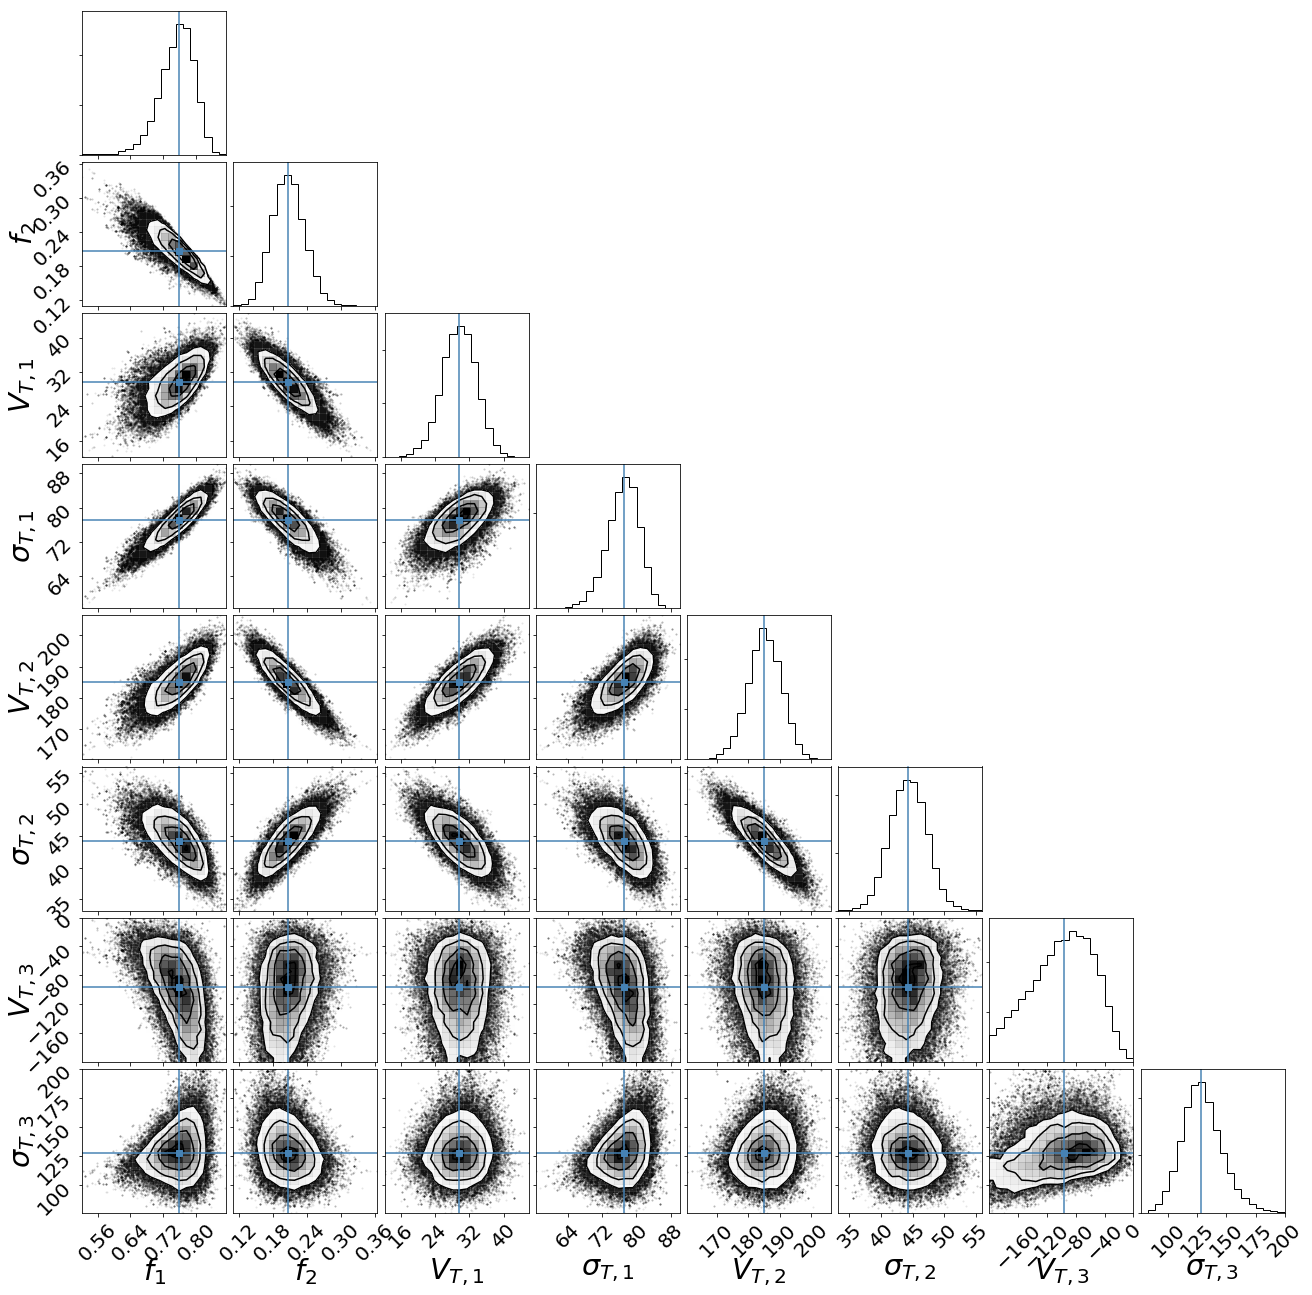

In [11]:
import corner
ss = np.sqrt(np.diag(Mpcov3))
print(ss)
print('f_1=%(f1).3f\pm%(f1e).3f,f_2=%(f2).3f\pm%(f2e).3f,' % {'f1':Mpopt3[0],'f1e':ss[0],'f2':Mpopt3[1],'f2e':ss[1]})
print('v_1=%(v1).0f \pm %(v1e).0f km/s,\sigma_1=%(s1).0f \pm %(s1e).0f km/s' % {'v1':Mpopt3[2],'v1e':ss[2],\
                                                    's1':Mpopt3[3],'s1e':ss[3]})
print('v_2=%(v2).0f \pm %(v2e).0f km/s,\sigma_2=%(s2).0f \pm %(s2e).0f km/s' % {'v2':Mpopt3[4],'v2e':ss[4],\
                                                    's2':Mpopt3[5],'s2e':ss[5]})
print('v_3=%(v3).0f \pm %(v3e).0f km/s,\sigma_3=%(s3).0f \pm %(s3e).0f km/s' % {'v3':Mpopt3[6],'v3e':ss[6],\
                                                    's3':Mpopt3[7],'s3e':ss[7]})
fig = corner.corner(samples3,labels=["$f_1$","$f_2$","$V_{T,1}$","$\sigma_{T,1}$","$V_{T,2}$","$\sigma_{T,2}$",\
                                    "$V_{T,3}$","$\sigma_{T,3}$"],\
                   truths=Mpopt3,fontsize=15)
# fig.savefig('/Users/htian/Documents/work/plots/rothalo/'+fn_tag+'rothalo_mcmc_result_all.eps',bbox_inches='tight')
for i in range(0,np.shape(samples3)[1]):
    print(i,np.percentile(samples3[:,i],(16,50,84)))

/Users/htian/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


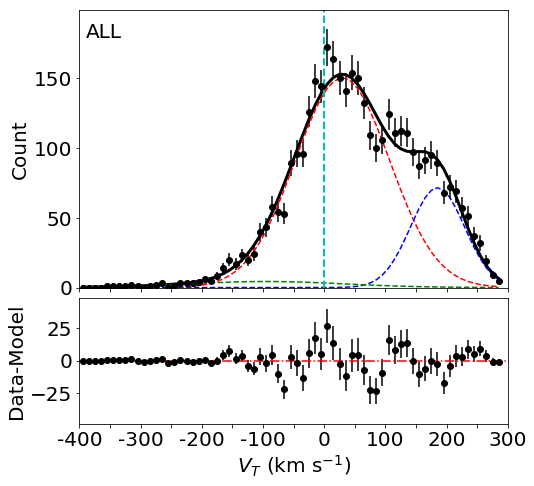

In [25]:
def draw_VT(vt,Mpopt3,filename,label=""):
    vgrid = np.arange(-400,300,10.)
    vcenter = (vgrid[:-1]+vgrid[1:])/2.
    fig = plt.figure(figsize=[7,7])
    ax = fig.add_axes([0.13,0.4,0.85,0.55])
    h,xedge = np.histogram(vt,vgrid)
    ax.errorbar(vcenter, h, yerr=np.sqrt(h),fmt='ko')
    g1 = Mpopt3[0]*stats.norm.pdf(vcenter,Mpopt3[2],Mpopt3[3])
    g2 = Mpopt3[1]*stats.norm.pdf(vcenter,Mpopt3[4],Mpopt3[5])
    g3 = (1-Mpopt3[0]-Mpopt3[1])*stats.norm.pdf(vcenter,Mpopt3[6],Mpopt3[7])
    g = g1+g2+g3
    ax.plot(vcenter, g/np.sum(g)*np.sum(h),'k-',linewidth=3)
    ax.plot(vcenter, g1/np.sum(g)*np.sum(h),'r--')
    ax.plot(vcenter, g2/np.sum(g)*np.sum(h),'b--')
    ax.plot(vcenter, g3/np.sum(g)*np.sum(h),'g--')
    max_y = np.max(g/np.sum(g)*np.sum(h))*1.3
    ax.text(-390,max_y*0.9,label,fontsize=20)
    ax.set_ylim([0,max_y])
    ax.plot([0,0],[0,max_y],'c--',linewidth=2)
    ax.set_xlim([-400,300])
    ax.set_xticks(np.arange(-400,350,50))
    ax.set_xticklabels([])
    ax.set_ylabel(r'Count',fontsize=20)

    ax = fig.add_axes([0.13,0.13,0.85,0.25])
    ax.errorbar(vcenter, h-g/np.sum(g)*np.sum(h),yerr=np.sqrt(h),fmt='ko')
    ax.plot([-400,300],[0,0],'r-.')
    ax.set_xlim([-400,300])
    ax.set_xticks(np.arange(-400,350,50))
    ax.set_xticklabels(['-400','','-300','','-200','','-100','','0','','100','','200','','300'])
    ax.set_ylim([-48,48])
    ax.set_ylabel('Data-Model',fontsize=20)
    ax.set_xlabel(r'$V_T$ (km s$^{-1}$)',fontsize=20)
    fig.show()

    fig.savefig(filename,bbox_inches='tight')

draw_VT(vt,Mpopt3,'/Users/htian/Documents/work/plots/rothalo/'+fn_tag+'rothalo_vt_distribution.eps',label='ALL')

In [13]:
# fehgrid = np.arange(-2.5,-0.7,0.3)
# fehgrid = np.array([-2.5,-2,-1.5,-1])
# fehgrid = np.array([-2.5,-1.5,-1])
fehgrid = np.array([-2.5,-1.6,-1.3,-1])
print(fehgrid)

[-2.5 -1.6 -1.3 -1. ]


In [14]:
# MMpopt3 = np.array([0.758,0.205,30,77,185,44,-95,128])
# label_all = "$all$"
# draw_VT(vt,MMpopt3,'/Users/htian/Documents/work/plots/rothalo/'+fn_tag+'rothalo_vt_distribution_allfeh.eps',label_all)
# MMFpopt3 = np.array([[0.599,0.052,35,84,196,60,-37,118],\
#                     [0.625,0.072,52,80,208,30,-34,112],\
#                     [0.867,0.056,32,87,167,53,-60,127],\
#                     [0.788,0.175,15,68,168,53,-118,162],\
#                     [0.558,0.396,27,64,179,46,-24,107]])
# labels_fehs= ["$-2.5<[Fe/H]<-2.2$","$-2.2<[Fe/H]<-1.9$","$-1.9<[Fe/H]<-1.6$",\
#               "$-1.6<[Fe/H]<-1.3$","$-1.3<[Fe/H]<-1$"]
# fn_feh = ["-2.5","-2.2","-1.9","-1.6","-1.3"]
# for i in range(0,5):
#     ind = (feh>=fehgrid[i]) & (feh<fehgrid[i+1])
#     draw_VT(vt[ind],MMFpopt3[i,:],'/Users/htian/Documents/work/plots/rothalo/'+fn_tag+\
#             'rothalo_vt_distribution_feh'+fn_feh[i]+'.eps',labels_fehs[i])


8
[ 7.48282569e-01  4.72070528e-02  4.09345057e+01  8.47848886e+01
  2.05227962e+02  3.55091837e+01 -4.31538061e+01  1.11398384e+02]
-2.5 62.950453996658325
-------------------------------------------------------
f_1=0.748\pm0.155,f_2=0.047\pm0.072,
v_1=41 \pm 12 km/s,\sigma_1=85 \pm 9 km/s
v_2=205 \pm 38 km/s,\sigma_2=36 \pm 19 km/s
v_3=-43 \pm 38 km/s,\sigma_3=111 \pm 14 km/s
0 [0.56441691 0.74828257 0.87268338]
1 [0.02650373 0.04720705 0.12066128]
2 [29.62381128 40.93450568 51.90446925]
3 [76.03254501 84.78488864 91.35241671]
4 [150.73063705 205.22796214 224.30721997]
5 [22.65248664 35.50918369 61.60343131]
6 [-87.9699668  -43.15380612 -14.87898453]
7 [103.68400724 111.3983844  126.04743942]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
8


/Users/htian/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


[   0.78163076    0.18250342   14.28767271   67.83409739  165.88750275
   53.955662   -117.27924865  159.39373785]
-1.6 69.8666627407074
-------------------------------------------------------
f_1=0.782\pm0.071,f_2=0.183\pm0.063,
v_1=14 \pm 7 km/s,\sigma_1=68 \pm 5 km/s
v_2=166 \pm 19 km/s,\sigma_2=54 \pm 9 km/s
v_3=-117 \pm 50 km/s,\sigma_3=159 \pm 22 km/s
0 [0.70107619 0.78163076 0.8431708 ]
1 [0.12611048 0.18250342 0.25345732]
2 [ 6.44484299 14.28767271 21.53872336]
3 [62.63592884 67.83409739 73.02192391]
4 [145.50059093 165.88750275 184.86896365]
5 [45.40535084 53.955662   63.18892889]
6 [-170.76732928 -117.27924865  -59.36695916]
7 [135.51304696 159.39373785 183.34273902]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
8
[  0.56362473   0.39360551  27.81362582  63.96627472 179.12840792
  46.03560835 -26.00440096 109.10419001]
-1.3 74.90330195426941
-------------------------------------------------------
f_1=0.564\pm0.070,f_2=0.394\pm0.044,
v_1=28 \pm 7 km/s,\sigma_1=64 \pm

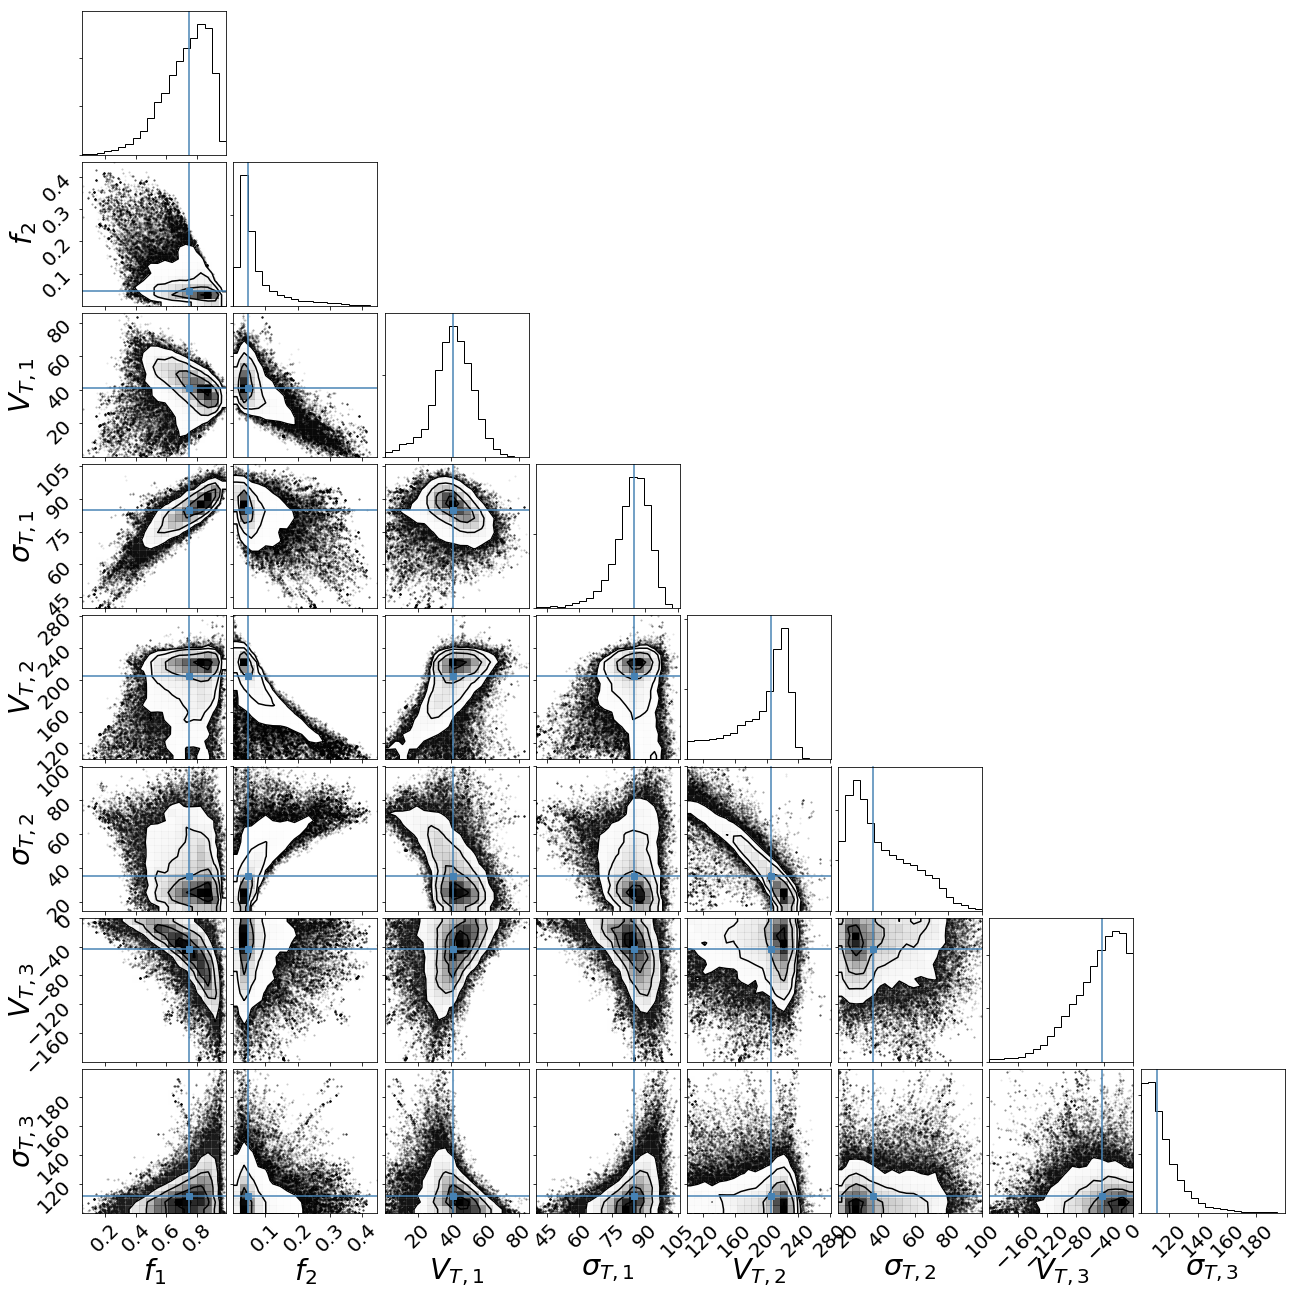

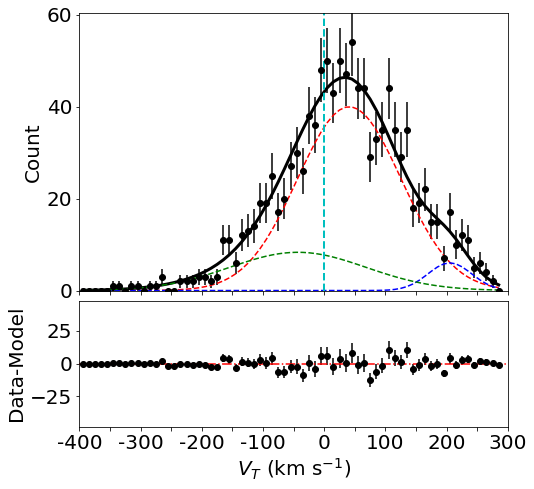

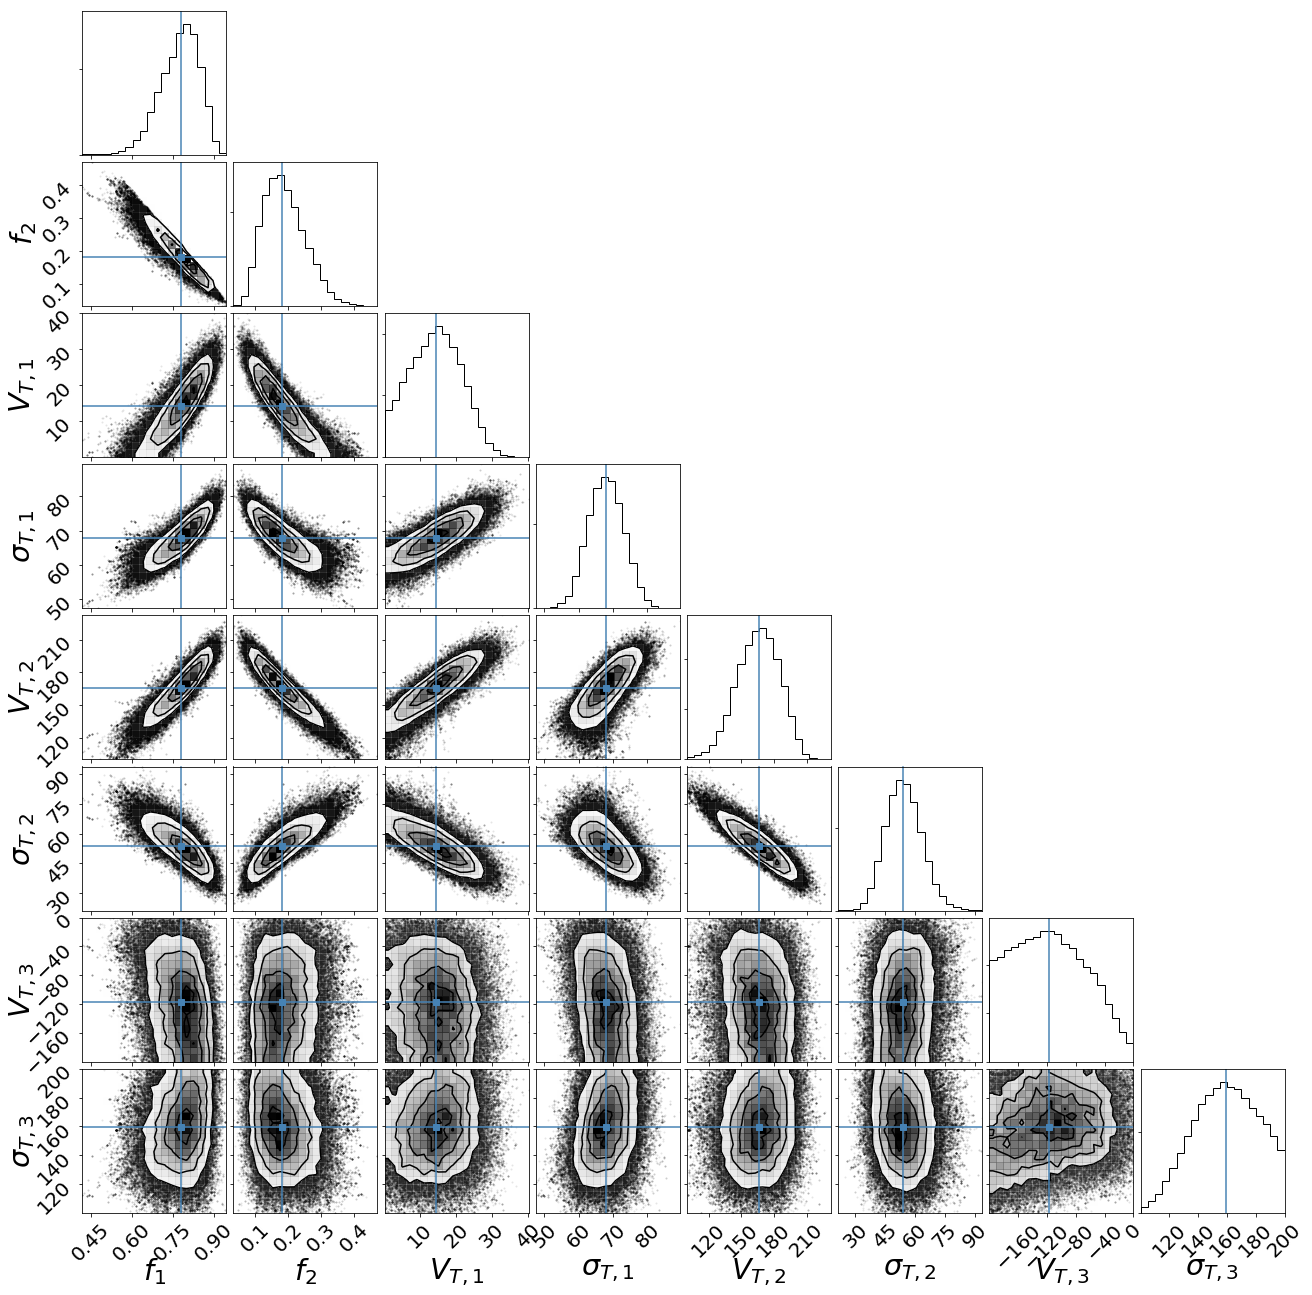

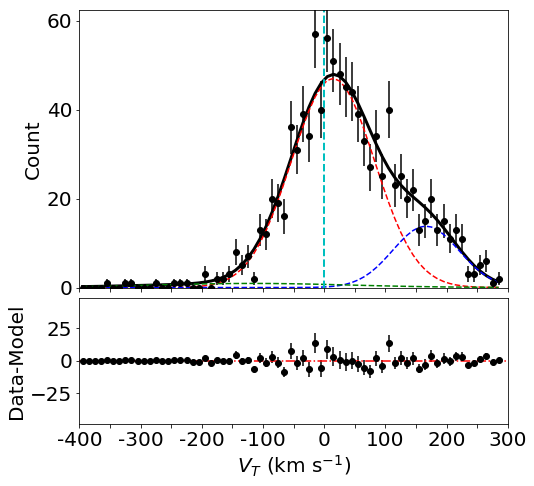

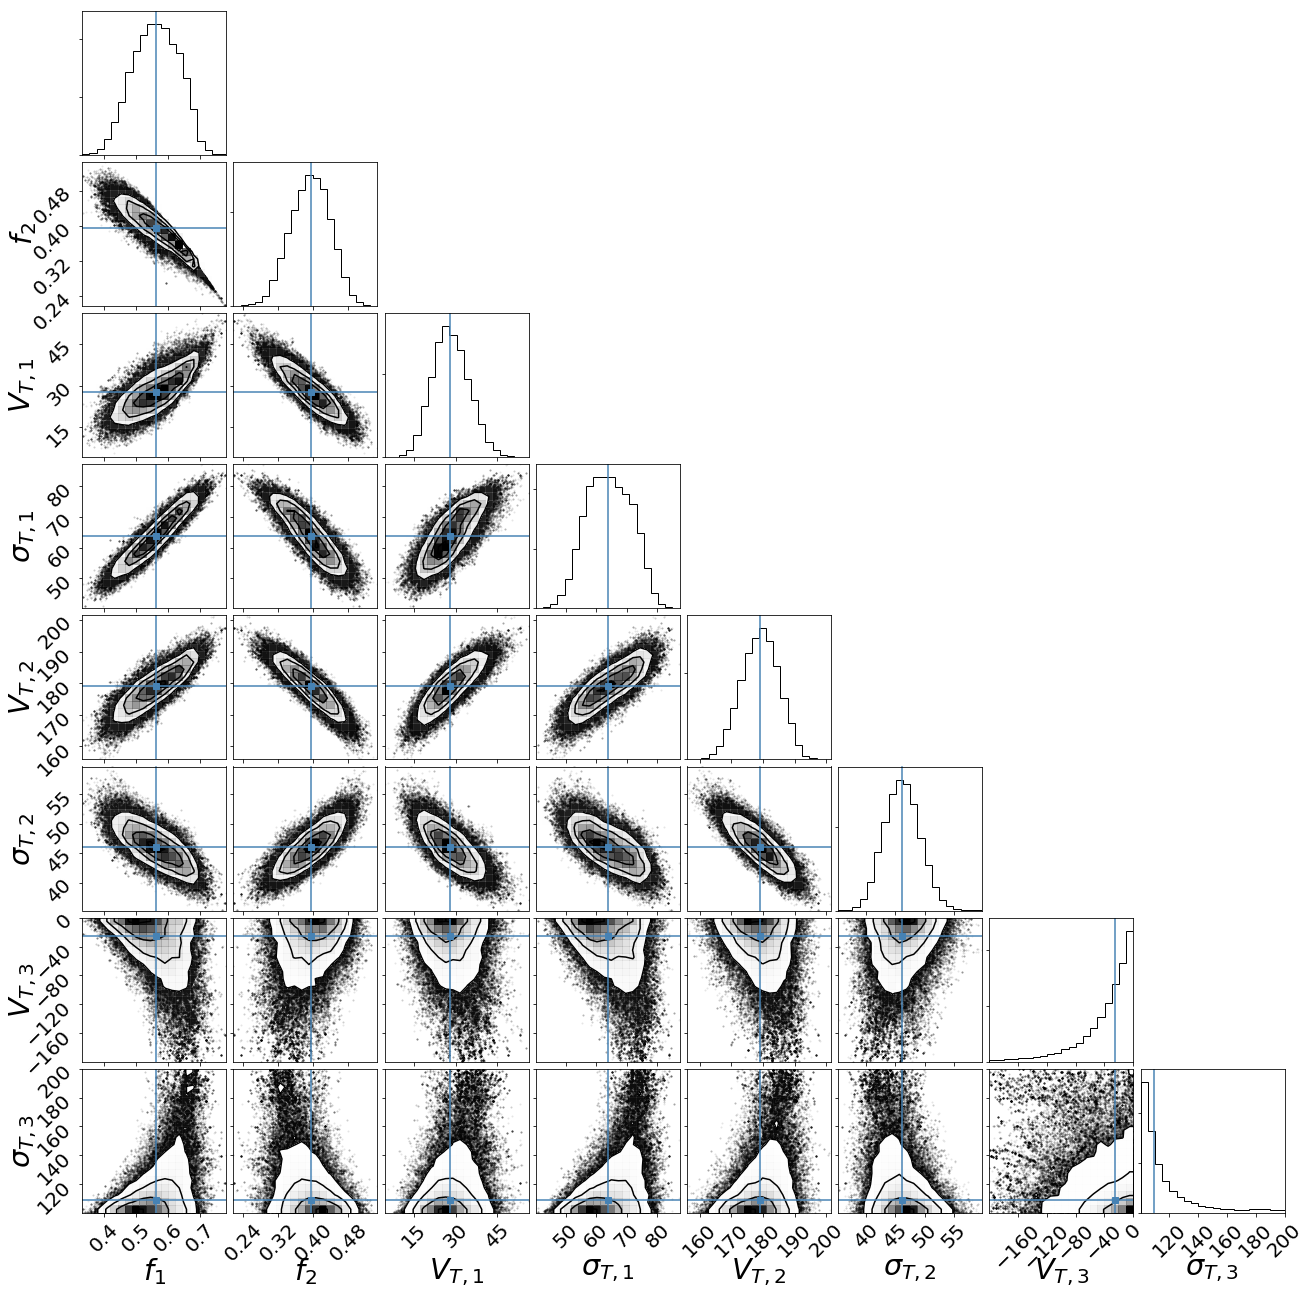

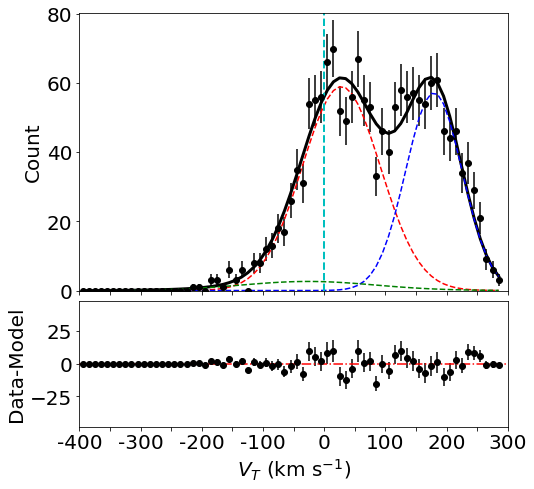

In [15]:
#f_1=0.722\pm0.034,f_2=0.239\pm0.022,
#v_1=25 \pm 3 km/s,\sigma_1=75 \pm 3 km/s
#v_2=179 \pm 4 km/s,\sigma_2=45 \pm 2 km/s
#v_3=-57 \pm 23 km/s,\sigma_3=137 \pm 14 km/s

def lnprob_gauss3m(x,y):
    #n = np.float(len(y))
    f1 = x[0]
    f2 = x[1]
    mu1 = x[2]
    sig1 = x[3]
    mu2 = x[4]
    sig2 = x[5]
    mu3 = x[6]
    sig3 = x[7]
    
    if np.isinf(f1) or np.isinf(f2) or np.isinf(mu1) or np.isinf(sig1) or\
                np.isinf(mu2) or np.isinf(sig2) or np.isinf(mu3) or np.isinf(sig3) or\
                f1<0 or f1>1 or f2<0 or f2>1 or (f1+f2)<0 or (f1+f2)>1 or\
                sig1<40 or sig2<15 or sig3<100 or\
                sig1>120 or sig2>100 or sig3>200 or\
                mu1>100 or mu1<0 or mu2>300 or mu2<100 or mu3>0 or mu3<-200:
        #print('.',end='')
        return -np.Inf
    g1 = f1*stats.norm.pdf(y,mu1,sig1)# np.exp(-(y-mu1)**2/(2*sig1**2))/(np.sqrt(2*np.pi)*sig1)
    g2 = f2*stats.norm.pdf(y,mu2,sig2)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
    g3 = (1-f1-f2)*stats.norm.pdf(y,mu3,sig3)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
    g = g1+g2+g3
    #print g
    ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
    logg = np.log(g[ind_g])
    ind_lg = logg>-1e100
    #print('+',end='')
    return np.sum(logg[ind_lg])

def gauss3m_model(y,p0,N, func, nwalkers):
    # MCMC sampling
    ndim = p0.shape[1]
    print(ndim)
    sampler = emcee.EnsembleSampler(nwalkers, \
            ndim, func,a = 1.8, args=[y])
    N_burn_in = 1000
    
    pos, prob, state = sampler.run_mcmc(p0, N_burn_in)
    sampler.reset()
    
    sampler.run_mcmc(pos, N)
    
    samples = sampler.chain[:, N_burn_in:, :].reshape((-1, ndim))
    #corner.corner(samples)
    popt = np.median(samples, axis=0)
    pcov = np.zeros((ndim,ndim))
    for i in range(ndim):
        for j in range(ndim):
            pcov[i,j] = (np.sum((samples[:,i]-popt[i])*\
                (samples[:,j]-popt[j])))/len(samples)
    return popt, pcov, samples



#print(lnprob_gauss3([0.6,0.1,30.,80.,180.,60,20,30.],vt))
nwalkers = 50
results_m = []
rcd = np.zeros((len(fehgrid)-1,4))
rcd = np.zeros((len(fehgrid)-1,6))
for i in range(len(fehgrid)-1):
    p0=np.zeros((nwalkers,ndim))
    p0[:,0] = np.random.rand(nwalkers)*0.2+0.6
    p0[:,1] = np.random.rand(nwalkers)*0.1+0.
    p0[:,2] = np.random.rand(nwalkers)*50+10
    p0[:,3] = np.random.rand(nwalkers)*60+60
    p0[:,4] = np.random.rand(nwalkers)*50+150
    p0[:,5] = np.random.rand(nwalkers)*40+30
    p0[:,6] = np.random.rand(nwalkers)*100-100
    p0[:,7] = np.random.rand(nwalkers)*60+100
    start = time.time()
    ind = (feh>=fehgrid[i]) & (feh<fehgrid[i+1])
    Mpopt3m,Mpcov3m, samples3m = gauss3m_model(vt[ind], p0, 5000, lnprob_gauss3m, nwalkers)
    results_m.append([Mpopt3m,Mpcov3m,samples3m])
    print(Mpopt3m)
    fig = corner.corner(samples3m,labels=["$f_1$","$f_2$","$V_{T,1}$","$\sigma_{T,1}$","$V_{T,2}$","$\sigma_{T,2}$",\
                                        "$V_{T,3}$","$\sigma_{T,3}$"],\
                       truths=Mpopt3m)
    fig.savefig('/Users/htian/Documents/work/plots/rothalo/'+fn_tag+'rothalo_mcmc_results_feh%(m).3f.eps' % {'m':fehgrid[i]})
    print(fehgrid[i],time.time()-start)
    draw_VT(vt[ind],Mpopt3m,'/Users/htian/Documents/work/plots/rothalo/'+fn_tag+'rothalo_vt_distribution_feh%(m).3f.eps' % {'m':fehgrid[i]},label=)
    print('-------------------------------------------------------')
    ssm = np.sqrt(np.diag(Mpcov3m))
    print('f_1=%(f1).3f\pm%(f1e).3f,f_2=%(f2).3f\pm%(f2e).3f,' % {'f1':Mpopt3m[0],'f1e':ssm[0],\
                                                                  'f2':Mpopt3m[1],'f2e':ssm[1]})
    print('v_1=%(v1).0f \pm %(v1e).0f km/s,\sigma_1=%(s1).0f \pm %(s1e).0f km/s' % {'v1':Mpopt3m[2],'v1e':ssm[2],\
                                                        's1':Mpopt3m[3],'s1e':ssm[3]})
    print('v_2=%(v2).0f \pm %(v2e).0f km/s,\sigma_2=%(s2).0f \pm %(s2e).0f km/s' % {'v2':Mpopt3m[4],'v2e':ssm[4],\
                                                        's2':Mpopt3m[5],'s2e':ssm[5]})
    print('v_3=%(v3).0f \pm %(v3e).0f km/s,\sigma_3=%(s3).0f \pm %(s3e).0f km/s' % {'v3':Mpopt3m[6],'v3e':ssm[6],\
                                                        's3':Mpopt3m[7],'s3e':ssm[7]})

    print('=======================================================')
    rcd[i,:] = Mpopt3m[2],ssm[2],Mpopt3m[4],ssm[4]
    rcd_per[i,:3] = np.percentile(samples3m[:,2],(16,50,84))
    rcd_per[i,3:] = np.percentile(samples3m[:,4],(16,50,84))
    for j in range(0,np.shape(samples3m)[1]):
        print(j,np.percentile(samples3m[:,j],(16,50,84)))
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++')

In [16]:
# draw_VT(vt[ind],Mpopt3m,'/share/data/cliu/pyw/rothalo/rothalo_vt_distribution_tmp.eps')

In [17]:
result_m_tab = np.zeros((len(fehgrid)-1,17))
for i in range(len(fehgrid)-1):
    [Mpopt3m,Mpcov3m,sample3m] = results_m[i]
    ss = np.sqrt(np.diag(Mpcov3m))
    print(ss)
    print('f_1=%(f1).3f\pm%(f1e).3f,f_2=%(f2).3f\pm%(f2e).3f,' % {'f1':Mpopt3m[0],'f1e':ss[0],'f2':Mpopt3m[1],'f2e':ss[1]})
    print('v_1=%(v1).0f \pm %(v1e).0f km/s,\sigma_1=%(s1).0f \pm %(s1e).0f km/s' % {'v1':Mpopt3m[2],'v1e':ss[2],\
                                                        's1':Mpopt3m[3],'s1e':ss[3]})
    print('v_2=%(v2).0f \pm %(v2e).0f km/s,\sigma_2=%(s2).0f \pm %(s2e).0f km/s' % {'v2':Mpopt3m[4],'v2e':ss[4],\
                                                        's2':Mpopt3m[5],'s2e':ss[5]})
    print('v_3=%(v3).0f \pm %(v3e).0f km/s,\sigma_3=%(s3).0f \pm %(s3e).0f km/s' % {'v3':Mpopt3m[6],'v3e':ss[6],\
                                                        's3':Mpopt3m[7],'s3e':ss[7]})
    result_m_tab[i,:]=np.array([fehgrid[i],Mpopt3m[0],Mpopt3m[1],\
                       Mpopt3m[2],Mpopt3m[3],Mpopt3m[4],Mpopt3m[5],Mpopt3m[6],\
                      Mpopt3m[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7]])

[ 0.15494631  0.07234034 12.16345878  8.70826497 38.00788512 18.82517957
 37.61981913 14.20358769]
f_1=0.748\pm0.155,f_2=0.047\pm0.072,
v_1=41 \pm 12 km/s,\sigma_1=85 \pm 9 km/s
v_2=205 \pm 38 km/s,\sigma_2=36 \pm 19 km/s
v_3=-43 \pm 38 km/s,\sigma_3=111 \pm 14 km/s
[ 0.07053393  0.06251528  7.02403564  5.08470351 19.31120765  8.91745041
 49.51694066 21.99574355]
f_1=0.782\pm0.071,f_2=0.183\pm0.063,
v_1=14 \pm 7 km/s,\sigma_1=68 \pm 5 km/s
v_2=166 \pm 19 km/s,\sigma_2=54 \pm 9 km/s
v_3=-117 \pm 50 km/s,\sigma_3=159 \pm 22 km/s
[ 0.069606    0.0441891   6.50491541  7.15602011  5.83995629  3.02104148
 39.07628561 22.37264689]
f_1=0.564\pm0.070,f_2=0.394\pm0.044,
v_1=28 \pm 7 km/s,\sigma_1=64 \pm 7 km/s
v_2=179 \pm 6 km/s,\sigma_2=46 \pm 3 km/s
v_3=-26 \pm 39 km/s,\sigma_3=109 \pm 22 km/s


In [18]:
# from joblib import dump,load
# dump((fehgrid,results_m,result_m_tab,Mpopt3,Mpcov3,samples3),'/share/data/cliu/pyw/rot_halo/MCMC_results.dump')

In [19]:
# for i in range(len(fehgrid)-1):
#     [Mpopt3m,Mpcov3m,sample3m] = results_m[i]
#     fig = corner.corner(samples3m,labels=["$f_1$","$f_2","$V_{T,1}$","$\sigma_{T,1}$","$V_{T,2}$","$\sigma_{T,2}$",\
#                                         "$V_{T,3}$","$\sigma_{T,3}$"],\
#                        truths=Mpopt3m)
#     #fig.savefig('/share/data/cliu/pyw/rot_halo/rothalo_mcmc_result_feh%(m).3f.eps' % {'m':fehgrid[i]},bbox_inches='tight')

In [20]:
# svlsr = np.linspace(212,247,8)
# #            halo                     ||               disc
# # mean vt, error vt, disp, error disp,|| mean vt, error vt, disp, error disp
# vtrcd = np.zeros((8,8))  
# vtrcd[0,:] = -6.7, 3.2, 70.6, 2.5,    145.8, 4.9, 53.9, 2.4     # 212
# vtrcd[1,:] = -0.8, 3.3, 71.2, 2.6,    152.2, 4.9, 53.1, 2.6     # 217
# vtrcd[2,:] =  3.9, 3.6, 71.2, 2.8,    156.5, 5.4, 53.5, 2.8     # 222
# vtrcd[3,:] =  8.8, 3.7, 71.3, 2.9,    161.8, 5.5, 53.3, 2.9     # 227
# vtrcd[4,:] = 13.5, 4.0, 71.0, 3.3,    166.4, 6.2, 54.0, 3.2     # 232
# vtrcd[5,:] = 18.4, 4.2, 71.2, 3.4,    171.2, 6.6, 54.2, 3.4     # 237
# vtrcd[6,:] = 23.4, 4.7, 71.4, 3.8,    176.1, 7.3, 54.5, 3.7     # 242
# vtrcd[7,:] = 29.7, 5.0, 72.5, 4.0,    182.6, 7.7, 53.7, 4.3     # 247
# fig = plt.figure(figsize=(6,4))
# ax = fig.add_axes([0.15,0.15,0.8,0.8])
# ax.fill_between(svlsr,vtrcd[:,0]-vtrcd[:,1],vtrcd[:,0]+vtrcd[:,1],color='blue',alpha=0.3)
# ax.fill_between(svlsr,vtrcd[:,2]-vtrcd[:,3],vtrcd[:,2]+vtrcd[:,3],color='cyan',alpha=0.3)
# ax.fill_between(svlsr,vtrcd[:,4]-vtrcd[:,5],vtrcd[:,4]+vtrcd[:,5],color='green',alpha=0.3)
# ax.fill_between(svlsr,vtrcd[:,6]-vtrcd[:,7],vtrcd[:,6]+vtrcd[:,7],color='magenta',alpha=0.3)
# ax.plot(svlsr,vtrcd[:,0],"k*--",linewidth=1.2,markersize=10)
# ax.plot(svlsr,vtrcd[:,2],"k*--",linewidth=1.2,markersize=10)
# ax.plot(svlsr,vtrcd[:,4],"k*--",linewidth=1.2,markersize=10)
# ax.plot(svlsr,vtrcd[:,6],"k*--",linewidth=1.2,markersize=10)
# popt_line_mh,pcov_line_mh = SO.curve_fit(line_fit,svlsr,vtrcd[:,0],bounds=([-1,-50000],[3000,200]))
# popt_line_dh,pcov_line_dh = SO.curve_fit(line_fit,svlsr,vtrcd[:,2],bounds=([-1,-50000],[3000,200]))
# popt_line_md,pcov_line_md = SO.curve_fit(line_fit,svlsr,vtrcd[:,4],bounds=([-1,-50000],[3000,200]))
# popt_line_dd,pcov_line_dd = SO.curve_fit(line_fit,svlsr,vtrcd[:,6],bounds=([-1,-50000],[3000,200]))

# sxx_line = np.linspace(210,250,10001)
# ax.plot(sxx_line,line_fit(sxx_line,*popt_line_mh),'r-',linewidth=1)
# ax.plot(sxx_line,line_fit(sxx_line,*popt_line_dh),'r-',linewidth=1)
# ax.plot(sxx_line,line_fit(sxx_line,*popt_line_md),'r-',linewidth=1)
# ax.plot(sxx_line,line_fit(sxx_line,*popt_line_dd),'r-',linewidth=1)
# ax.axis([210,250,-25,200])
# ax.set_xlabel("$V_{LSR}$",fontsize=15)
# ax.set_ylabel("<$V_T$> or $\sigma_{V_T}$",fontsize=15)

# # plt.savefig(ppath+"VT_VLSR.eps")

[-2.5 -1.6 -1.3 -1. ]


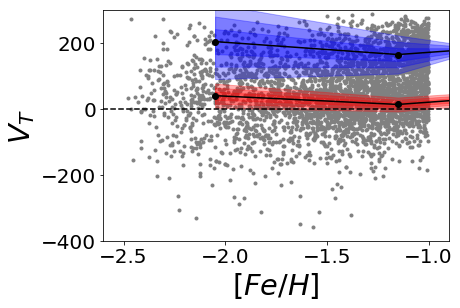

In [21]:
# rcd = np.zeros((5,4))
# feh_grid = np.linspace(-2.5,-1,6)[1:]-0.15
#        halo       ||          disc
# mean vt, error vt,|| mean vt, error vt, 
# rcd[0,:] = 36,11,194,31
# rcd[1,:] = 35,10,160,24
# rcd[2,:] = 27,8,156,17
# rcd[3,:] = 19,5,174,11
# rcd[4,:] = 21,4,176,3

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.15,0.15,0.8,0.8])
ax.scatter(feh,vt,marker=".",color="gray")
ax.plot([-5,0],[0,0],'k--')
ax.fill_between(fehgrid[:-1]+0.5*(fehgrid[1]-fehgrid[0]),rcd[:,0]-rcd[:,1]*1,rcd[:,0]+rcd[:,1]*1,color='r',alpha=0.3)
ax.fill_between(fehgrid[:-1]+0.5*(fehgrid[1]-fehgrid[0]),rcd[:,0]-rcd[:,1]*2,rcd[:,0]+rcd[:,1]*2,color='r',alpha=0.3)
ax.fill_between(fehgrid[:-1]+0.5*(fehgrid[1]-fehgrid[0]),rcd[:,0]-rcd[:,1]*3,rcd[:,0]+rcd[:,1]*3,color='r',alpha=0.3)
ax.fill_between(fehgrid[:-1]+0.5*(fehgrid[1]-fehgrid[0]),rcd[:,2]-rcd[:,3]*1,rcd[:,2]+rcd[:,3]*1,color='b',alpha=0.3)
ax.fill_between(fehgrid[:-1]+0.5*(fehgrid[1]-fehgrid[0]),rcd[:,2]-rcd[:,3]*2,rcd[:,2]+rcd[:,3]*2,color='b',alpha=0.3)
ax.fill_between(fehgrid[:-1]+0.5*(fehgrid[1]-fehgrid[0]),rcd[:,2]-rcd[:,3]*3,rcd[:,2]+rcd[:,3]*3,color='b',alpha=0.3)
ax.plot(fehgrid[:-1]+0.5*(fehgrid[1]-fehgrid[0]),rcd[:,0],"ko-")
ax.plot(fehgrid[:-1]+0.5*(fehgrid[1]-fehgrid[0]),rcd[:,2],"ko-")
ax.set_xlim([-2.6,-0.9])
ax.set_ylim([-400,300])
ax.set_xlabel("$[Fe/H]$")
ax.set_ylabel("$V_T$")
plt.savefig("/Users/htian/Documents/work/plots/rothalo/"+fn_tag+"VT_FEH_MCMC.pdf",bbox_inches='tight')


fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.15,0.15,0.8,0.8])
ax.scatter(feh,vt,marker=".",color="gray")
ax.plot([-5,0],[0,0],'k--')
mid_fehgrid = (fehgrid[:-1]+fehgrid[1:])*0.5
ax.fill_between(mid_fehgrid,rcd_per[:,0],rcd_per[:,2],color='r',alpha=0.5)
# ax.fill_between(mid_fehgrid,rcd[:,0]-rcd[:,1]*2,rcd[:,0]+rcd[:,1]*2,color='r',alpha=0.3)
# ax.fill_between(mid_fehgrid,rcd[:,0]-rcd[:,1]*3,rcd[:,0]+rcd[:,1]*3,color='r',alpha=0.3)
ax.fill_between(mid_fehgrid,rcd_per[:,3],rcd_per[:,5],color='b',alpha=0.5)
# ax.fill_between(mid_fehgrid,rcd[:,2]-rcd[:,3]*2,rcd[:,2]+rcd[:,3]*2,color='b',alpha=0.3)
# ax.fill_between(mid_fehgrid,rcd[:,2]-rcd[:,3]*3,rcd[:,2]+rcd[:,3]*3,color='b',alpha=0.3)
ax.plot(mid_fehgrid,rcd_per[:,1],"ko-")
ax.plot(mid_fehgrid,rcd_per[:,4],"ko-")
ax.set_xlim([-2.6,-0.9])
ax.set_ylim([-400,300])
ax.set_xlabel("$[Fe/H]$")
ax.set_ylabel("$V_T$")
plt.savefig("/Users/htian/Documents/work/plots/rothalo/00000per_"+fn_tag+"VT_FEH_MCMC.pdf",bbox_inches='tight')
print(fehgrid)

In [22]:
A_vlsr = np.array([220,232,240])

In [23]:
# rcd = np.zeros((5,4))
# feh_grid = np.linspace(-2.5,-1,6)[1:]-0.15
# #        halo       ||          disc
# # mean vt, error vt,|| mean vt, error vt, 
# rcd[0,:] = 36,11,194,31
# rcd[1,:] = 35,10,160,24
# rcd[2,:] = 27,8,156,17
# rcd[3,:] = 19,5,174,11
# rcd[4,:] = 21,4,176,3

# fig = plt.figure(figsize=(6,4))
# ax = fig.add_axes([0.15,0.15,0.8,0.8])
# ax.scatter(feh,vt,marker=".",color="gray")
# ax.plot([-2.5,-1],[0,0],'k--')
# ax.fill_between(feh_grid,rcd[:,0]-rcd[:,1]*1,rcd[:,0]+rcd[:,1]*1,color='r',alpha=0.3)
# ax.fill_between(feh_grid,rcd[:,0]-rcd[:,1]*2,rcd[:,0]+rcd[:,1]*2,color='r',alpha=0.3)
# ax.fill_between(feh_grid,rcd[:,0]-rcd[:,1]*3,rcd[:,0]+rcd[:,1]*3,color='r',alpha=0.3)
# ax.fill_between(feh_grid,rcd[:,2]-rcd[:,3]*1,rcd[:,2]+rcd[:,3]*1,color='b',alpha=0.3)
# ax.fill_between(feh_grid,rcd[:,2]-rcd[:,3]*2,rcd[:,2]+rcd[:,3]*2,color='b',alpha=0.3)
# ax.fill_between(feh_grid,rcd[:,2]-rcd[:,3]*3,rcd[:,2]+rcd[:,3]*3,color='b',alpha=0.3)
# ax.plot(feh_grid,rcd[:,0],"ko-")
# ax.plot(feh_grid,rcd[:,2],"ko-")
# ax.set_xlim([-2.5,-1])
# ax.set_ylim([-200,300])
# ax.set_xlabel("$[Fe/H]$")
# ax.set_ylabel("$V_T$")
# plt.savefig("/Users/htian/Documents/work/plots/rothalo/000000VT_FEH_MCMC.pdf",bbox_inches='tight')
# print(rcd[:,0])

In [24]:
print(rcd)
print(feh_grid)

[[ 40.93450568  12.16345878 205.22796214  38.00788512]
 [ 14.28767271   7.02403564 165.88750275  19.31120765]
 [ 27.81362582   6.50491541 179.12840792   5.83995629]]


NameError: name 'feh_grid' is not defined

# print((19+15/60+0.541/3600)*15)
print(41+13/60+55.04/3600)